In [2]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

import pandas as pd

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

In [4]:
movies = pd.read_csv('../ml-1m/movies.dat', sep=r"::", header=None, engine='python', encoding='latin-1')

In [185]:
ratings = pd.read_csv('../ml-1m/ratings.dat', sep=r"::", header=None, engine='python')
users = pd.read_csv('../ml-1m/users.dat', sep=r"::", header=None, engine='python')

In [6]:
movies.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [8]:
users.head()

,0,1,2,3,4
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [186]:
selected_movies = movies.iloc[:, [0, 1, 2]] 
selected_ratings = ratings.iloc[:, [0, 1, 2]]
selected_users = users.iloc[:, [0, 1, 2]]

In [187]:
# Дадим новые названия столбцам
selected_movies.columns = ['iid', 'Title', 'Genres']
selected_ratings.columns = ['uid', 'iid', 'Rating']
selected_users.columns = ['uid', 'Gender', 'Age']

In [192]:
(selected_users['Gender'] == 'M').sum()

4331

In [116]:
selected_ratings.Rating.isna().sum() , selected_ratings.Rating.shape

(0, (1000209,))

In [44]:
selected_movies.head()

,iid,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [195]:
merged_data = pd.merge(pd.merge(selected_ratings, selected_movies, on='iid'), selected_users, on='uid')

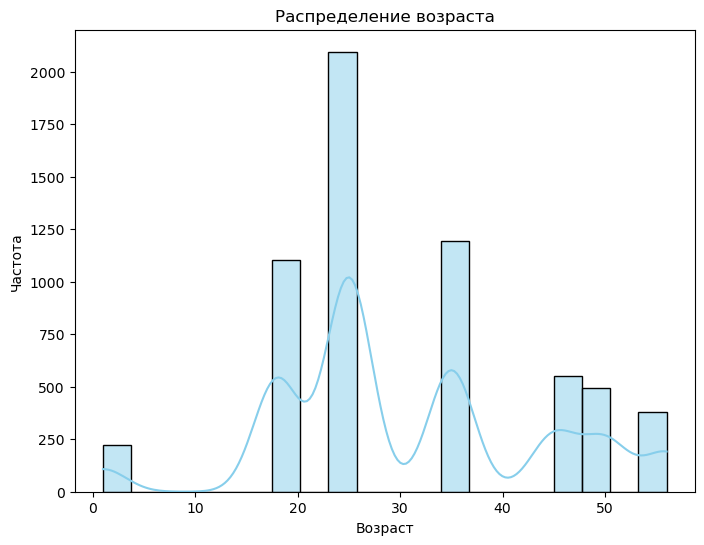

In [193]:
# Построим гистограмму распределения возраста
plt.figure(figsize=(8, 6))
sns.histplot(selected_users['Age'], bins=20, kde=True, color='skyblue')
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

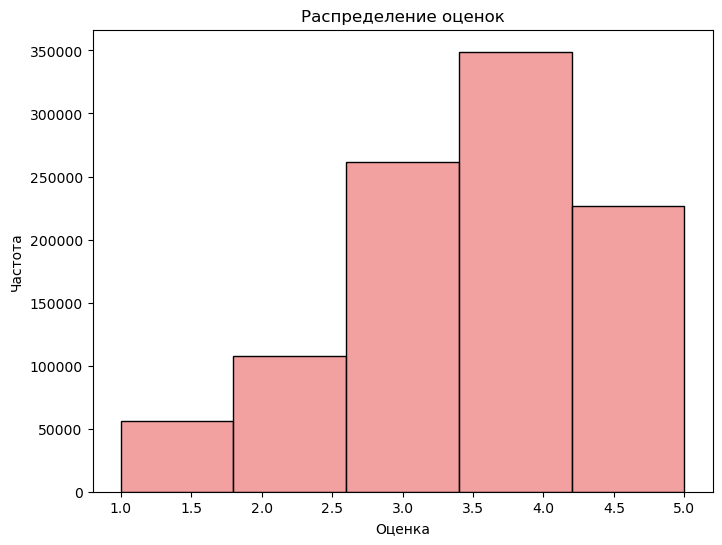

In [32]:
# Построим гистограмму распределения оценок
plt.figure(figsize=(8, 6))
sns.histplot(selected_ratings['Rating'], bins=5, color='lightcoral')
plt.title('Распределение оценок')
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.show()

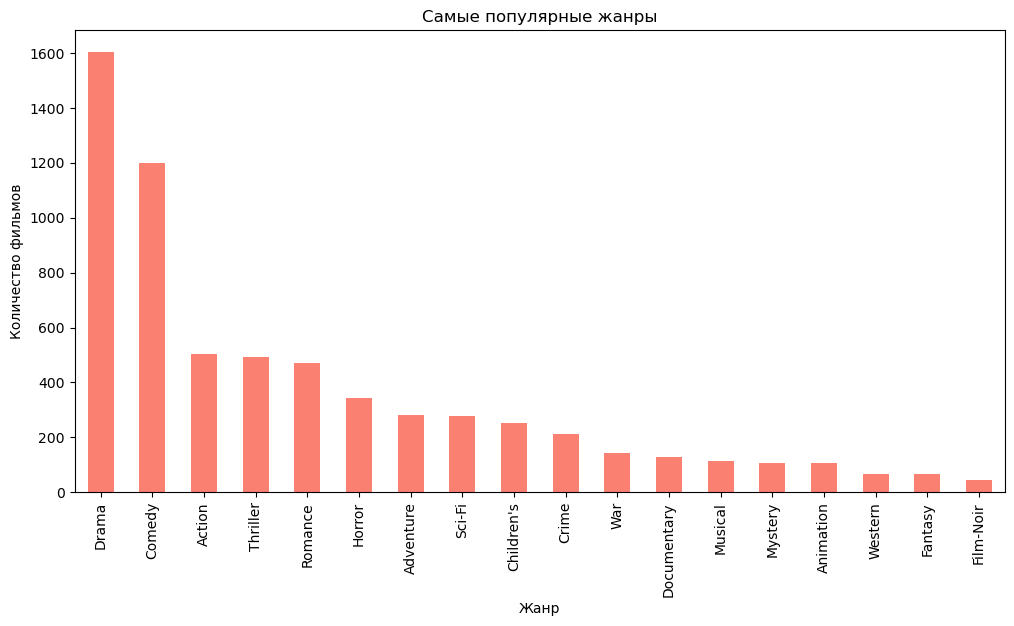

In [46]:
# Создадим DataFrame с разделенными жанрами
genres_df = selected_movies['Genres'].str.get_dummies('|')

# Посчитаем общее количество фильмов для каждого жанра
total_movies_by_genre = genres_df.sum().sort_values(ascending=False)

# Построим столбчатую диаграмму
plt.figure(figsize=(12, 6))
total_movies_by_genre.plot(kind='bar', color='salmon')
plt.title('Самые популярные жанры')
plt.xlabel('Жанр')
plt.ylabel('Количество фильмов')
plt.show()


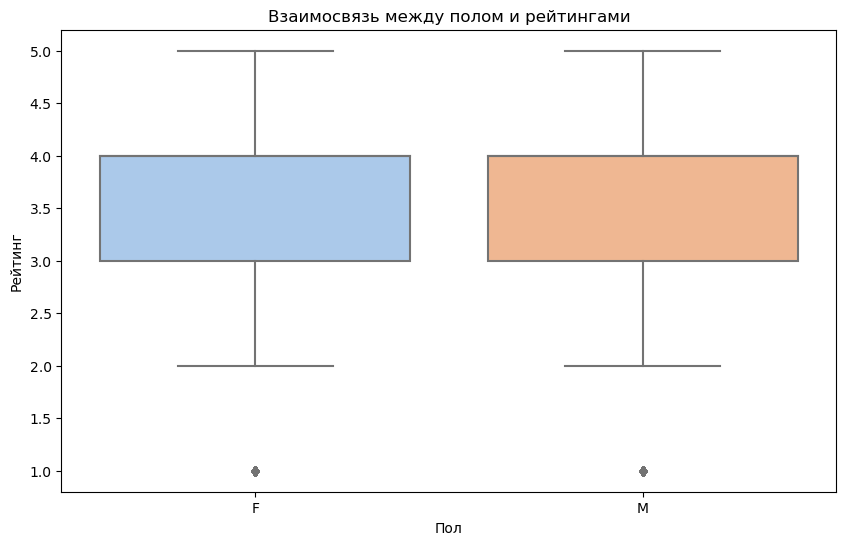

In [196]:
# Построим ящик с усами (boxplot) для визуализации взаимосвязи между полом и рейтингами
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='Rating', data=merged_data, palette='pastel')
plt.title('Взаимосвязь между полом и рейтингами')
plt.xlabel('Пол')
plt.ylabel('Рейтинг')
plt.show()

In [201]:
(merged_data.Gender == 'F').sum() , (merged_data.Gender == 'M').sum()

(246440, 753769)

In [50]:
movies_with_ratings = selected_movies.join(selected_ratings.set_index('iid'), on='iid').reset_index(drop=True)
movies_with_ratings.dropna(inplace=True)

In [51]:
movies_with_ratings.Rating.min() , movies_with_ratings.Rating.max()

(1.0, 5.0)

In [52]:
reader = Reader(rating_scale=(1, 5))

In [101]:
dataset = pd.DataFrame({
    'uid': movies_with_ratings.uid,
    'iid': movies_with_ratings.Title,
    'numid': movies_with_ratings.iid,
    'rating': movies_with_ratings.Rating
})

In [54]:
data = Dataset.load_from_df(dataset, reader)

In [55]:
trainset, testset = train_test_split(data, test_size=.15, random_state=42)

In [70]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [3, 5, 10, 20], 'n_epochs': [10, 20, 30, 40, 50, 60]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
gs.fit(data)
print(gs.best_params['rmse'])


{'n_factors': 10, 'n_epochs': 60}


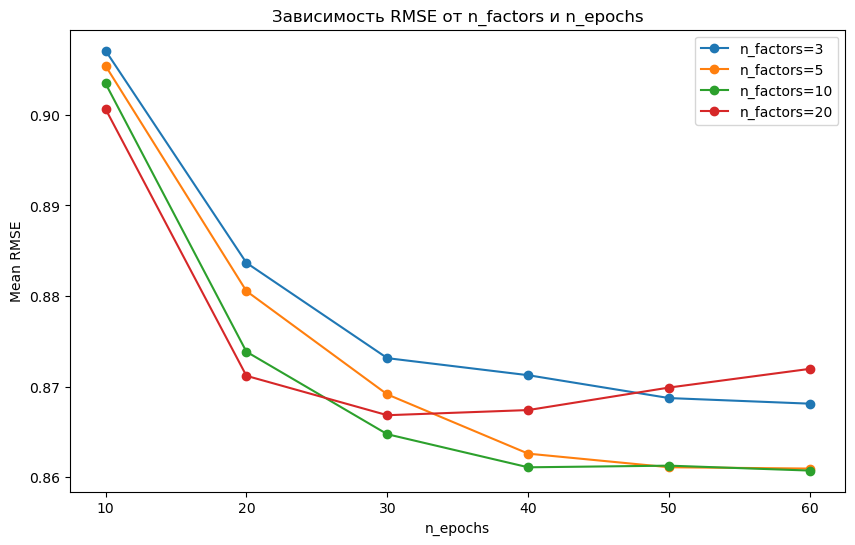

In [71]:
# Получите результаты GridSearchCV
results_df = pd.DataFrame.from_dict(gs.cv_results)

# Визуализация результатов
plt.figure(figsize=(10, 6))

for factor in param_grid['n_factors']:
    subset = results_df[results_df['param_n_factors'] == factor]
    plt.plot(subset['param_n_epochs'], subset['mean_test_rmse'], marker='o', label=f'n_factors={factor}')

plt.title('Зависимость RMSE от n_factors и n_epochs')
plt.xlabel('n_epochs')
plt.ylabel('Mean RMSE')
plt.legend()
plt.show()

In [72]:
%%time
algo = SVD(n_factors=10, n_epochs=60)
algo.fit(trainset)

CPU times: user 13.6 s, sys: 271 ms, total: 13.9 s
Wall time: 14 s


In [79]:
test_pred = algo.test(testset)

In [80]:
accuracy.rmse(test_pred, verbose=True)

RMSE: 0.8583


0.858316915353809

In [81]:
algo.predict(uid=2.0, iid='Mortal Kombat (1995)').est

2.3802125197055974

In [82]:
cv_results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8631  0.8601  0.8586  0.8608  0.8615  0.8608  0.0015  
Fit time          13.67   14.48   14.35   14.73   14.63   14.37   0.37    
Test time         1.18    1.58    1.57    1.15    1.58    1.41    0.20    


In [83]:
print(f'Среднее значение RMSE: {cv_results["test_rmse"].mean()}')

Среднее значение RMSE: 0.860818508803036


In [84]:
from surprise import KNNBasic

model_knn = KNNBasic()

In [85]:
cv_results = cross_validate(model_knn, data, measures=['RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9218  0.9239  0.9240  0.9236  0.9203  0.9227  0.0015  
Fit time          12.85   13.05   13.23   13.24   13.19   13.11   0.15    
Test time         65.99   66.59   67.07   69.84   68.57   67.61   1.40    


In [86]:
print(f'Среднее значение RMSE для KNN: {cv_results["test_rmse"].mean()}')

Среднее значение RMSE: 0.9227251055903984


In [203]:
cv_results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)
print(f'Среднее значение RMSE для SVD: {cv_results["test_rmse"].mean()}')

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8612  0.8589  0.8610  0.8649  0.8593  0.8611  0.0021  
Fit time          15.37   14.94   15.08   14.74   15.09   15.04   0.21    
Test time         3.44    2.06    1.44    2.65    1.55    2.23    0.74    
Среднее значение RMSE для SVD: 0.8610794273374646
